# Walmart Sales: EDA Part II

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module.global_plot_functions as gp

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, FactorRange

sns.set()
output_notebook()

Loading BokehJS ...

In [2]:
# load data
stores = pd.read_pickle('out/stores.pkl')
features = pd.read_pickle('out/features.pkl')
sales = pd.read_pickle('out/sales.pkl')
store_sales = pd.read_pickle('out/store_sales.pkl')

In [3]:
store_sales.head()

,Store,Date,Weekly Sales (Thousands),Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Total MarkDown,Week,Month,Year,Quarter
0,1,2010-02-05,1643.69090,42.31,2.572,211.096358,8.106,False,NaN,5,2,2010,1
1,1,2010-02-12,1641.95744,38.51,2.548,211.242170,8.106,True,NaN,6,2,2010,1
2,1,2010-02-19,1611.96817,39.93,2.514,211.289143,8.106,False,NaN,7,2,2010,1
3,1,2010-02-26,1409.72759,46.63,2.561,211.319643,8.106,False,NaN,8,2,2010,1
4,1,2010-03-05,1554.80668,46.50,2.625,211.350143,8.106,False,NaN,9,3,2010,1


In [4]:
# total weekly sales
weekly_sales = store_sales.groupby(by=['Date', 'IsHoliday', 'Month', 
                                       'Quarter', 'Year'])['Weekly Sales (Thousands)'].sum().to_frame().reset_index()
weekly_sales['Weekly Sales (Millions)'] = weekly_sales['Weekly Sales (Thousands)'] / 1000
del weekly_sales['Weekly Sales (Thousands)']

# holiday sales
holiday_sales = weekly_sales[weekly_sales.IsHoliday == True]

In [5]:
weekly_sales.head()

,Date,IsHoliday,Month,Quarter,Year,Weekly Sales (Millions)
0,2010-02-05,False,2,1,2010,49.750740
1,2010-02-12,True,2,1,2010,48.336678
2,2010-02-19,False,2,1,2010,48.276994
3,2010-02-26,False,2,1,2010,43.968571
4,2010-03-05,False,3,1,2010,46.871470


In [6]:
holidays = pd.DataFrame(dict({'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2012-02-08'],
                 'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
                 'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
                 'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']}))
for col_name in holidays.columns:
    holidays[col_name] = pd.to_datetime(holidays[col_name])

In [7]:
def assign_holiday(date):
    global holidays
    
    for col_name in holidays.columns:
        isHoliday = holidays[col_name] == date
        if len( holidays[isHoliday]) > 0:
            return col_name
    return ''

pd.options.mode.chained_assignment = None
holiday_sales['Holiday'] = holiday_sales['Date'].apply(assign_holiday)
holiday_sales.head()

,Date,IsHoliday,Month,Quarter,Year,Weekly Sales (Millions),Holiday
1,2010-02-12,True,2,1,2010,48.336678,Super Bowl
31,2010-09-10,True,9,3,2010,45.634398,Labor Day
42,2010-11-26,True,11,4,2010,65.821003,Thanksgiving
47,2010-12-31,True,12,4,2010,40.432519,Christmas
53,2011-02-11,True,2,1,2011,47.336193,Super Bowl


## General Trend

In [8]:
from sklearn.linear_model import LinearRegression

trend_model = LinearRegression(normalize=True, fit_intercept=True)
trend_model.fit(np.array(weekly_sales.index).reshape((-1,1)), weekly_sales['Weekly Sales (Millions)'])
predicts = trend_model.predict(np.array(weekly_sales.index).reshape((-1,1)))
weekly_sales['Residuals'] = weekly_sales['Weekly Sales (Millions)'] - predicts

print('Trend model:')
print('\tcoefficient: {}'.format(trend_model.coef_[0]))
print('\tintercept: {}'.format(trend_model.intercept_))

Trend model:
	coefficient: 0.004275137511244603
	intercept: 46.80988472698136


In [9]:
# plot weekly sales and mark the holiday week with circle

source = ColumnDataSource(data=weekly_sales)
hover = HoverTool(tooltips=[("Month", "@Month"),
                            ("Sales", "$y")])

p = figure(x_axis_type="datetime", title="Walmart's Weekly Sales", plot_height=400, plot_width=800, tools=[hover])
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Weekly Sales (Millions USD)'

# draw line plot
p.line(x='Date',y='Weekly Sales (Millions)', source=source)

# draw trend line
p.line(x=weekly_sales['Date'], y=predicts, color='gray', line_dash='dashed',
       legend_label='y = {0} + {1}x'.format(round(trend_model.intercept_,2), round(trend_model.coef_[0],5)))

# draw circle plot to indicate the holiday in certain week
holiday_colors = ['orange', 'red', 'green', 'magenta']
for index, holiday in enumerate(['Labor Day', 'Super Bowl', 'Thanksgiving', 'Christmas']):
    data = holiday_sales[holiday_sales['Holiday'] == holiday]
    source1 = ColumnDataSource(data=data)
    p.circle(x='Date', y='Weekly Sales (Millions)', source=source1, size=7, color=holiday_colors[index],
        legend_label=holiday)

p.legend.location = "top_right"
p.legend.click_policy="hide"
show(p)

In [10]:
# plot residuals of trend model

p = figure(x_axis_type="datetime", title="Residuals of Trend Model for Weekly Sales", 
           plot_height=300, plot_width=800)

p.line(x=weekly_sales['Date'], y=weekly_sales['Residuals'])
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Weekly Sales (Millions)'
p.xaxis.formatter.days = '%m/%d/%Y'
show(p)

## Seasonality

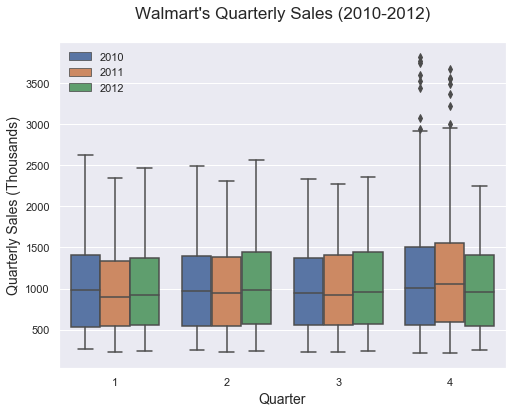

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
_ = sns.boxplot('Quarter', 'Weekly Sales (Thousands)', data=store_sales, hue='Year', ax=ax)
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Quarter', size=14)
plt.ylabel('Quarterly Sales (Thousands)', size=14)
plt.title('Walmart\'s Quarterly Sales (2010-2012)\n', size=17)
plt.show()

In [12]:
seasonal_sales = weekly_sales.groupby(by=['Year', 'Month'])['Residuals'].aggregate([np.mean, np.std])
seasonal_sales.columns = ['Monthly Mean', 'Monthly Standard Deviation']
seasonal_sales.head()

Monthly Mean  Monthly Standard Deviation
Year Month                                          
2010 2          0.766948                    2.509140
     3         -1.353447                    1.186971
     4         -0.570162                    2.678963
     5         -0.194141                    1.707953
     6          1.172568                    1.519776

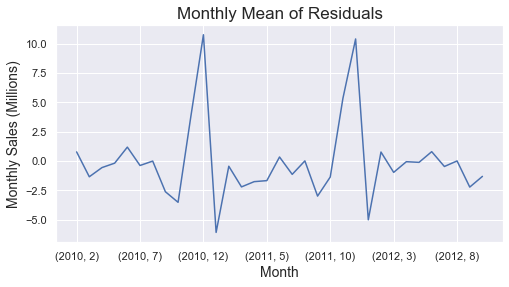

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
seasonal_sales['Monthly Mean'].plot()
plt.xlabel('Month', size=14)
plt.ylabel('Monthly Sales (Millions)', size=14)
plt.title('Monthly Mean of Residuals', size=17)
plt.show()

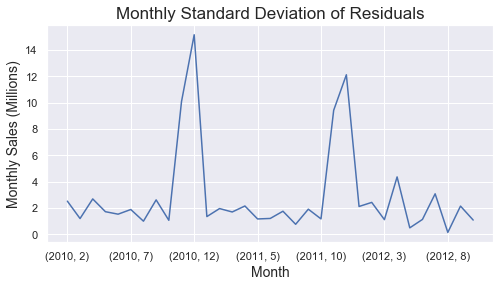

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
seasonal_sales['Monthly Standard Deviation'].plot()
plt.xlabel('Month', size=14)
plt.ylabel('Monthly Sales (Millions)', size=14)
plt.title('Monthly Standard Deviation of Residuals', size=17)
plt.show()